In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from sklearn.svm import SVR
from sklearn import datasets, metrics, preprocessing
from sklearn.metrics.pairwise import check_pairwise_arrays,pairwise_distances
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

define a function that takes an input $x$ and gives two outputs ($y_1=x$,  $y_2=x^2+2$). Give as input a batch of 1000 samples selected from a normal dustribution. The outputs are then two different distributions.
I used here a kernel density to estimate the densities of the outputs.
results are plotted below

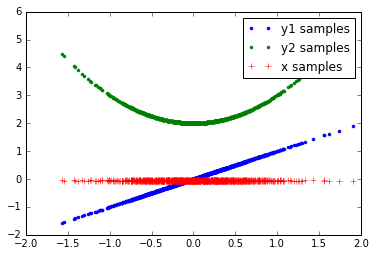

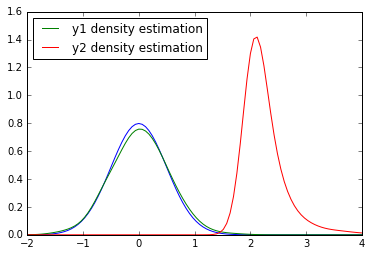

In [3]:
def func(x):
    return x, x**2+2

N = 1000 #number of samples
a = np.random.normal(0, 0.5, N)

y1_true, y2_true = func(a)

plt.plot(a,y1_true,'b.', label='y1 samples')
plt.plot(a,y2_true,'g.', label='y2 samples')
plt.plot(a, -0.05 - 0.01 * np.random.random(a.shape[0]), '+r', label='x samples')
plt.legend()

plt.figure()

X_plot = np.linspace(-2, 4, 100)[:, np.newaxis]
kde_y1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y1_true[:,None])
kde_y2 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y2_true[:,None])

y1_dens = norm(0, 0.5).pdf(X_plot[:, 0])
y2_dens = norm(2, 0.5).pdf(X_plot[:, 0])
plt.plot(X_plot,y1_dens)
plt.plot(X_plot,np.exp(kde_y1.score_samples(X_plot)), label='y1 density estimation')
plt.plot(X_plot,np.exp(kde_y2.score_samples(X_plot)), label='y2 density estimation')
plt.legend(loc='best')

next a simulated prediction is created by adding random noise to both outputs. More noise is added to y1 here.
The r2 scores are computed, first by calculating the raw values of each output, second by calculating the mean average of both, and third by weighting the average with the variance of each output.

In [4]:
#simulating a bad regressor for y1 and good for y2
y1_pred = y1_true + 0.7 * np.random.random(y1_true.shape[0]) #add noise to 
y2_pred = y2_true + 0.1 * np.random.random(y2_true.shape[0])

y_true = np.vstack((y1_true, y2_true)).T
y_pred = np.vstack((y1_pred, y2_pred)).T


print 'raw values:        ', r2_score(y_true, y_pred, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true, y_pred, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true, y_pred, multioutput='variance_weighted')

raw values:         [ 0.35011512  0.97679365]
uniform average:    0.663454382724
variance_weighted:  0.58236201141


Same is done here, but with y2 have more noise than y1

In [5]:
#simulating a bad regressor for y2 and good for y1
y1_pred = y1_true + 0.1 * np.random.random(y1_true.shape[0])
y2_pred = y2_true + 0.5 * np.random.random(y2_true.shape[0])

y_true = np.vstack((y1_true, y2_true)).T
y_pred = np.vstack((y1_pred, y2_pred)).T


print 'raw values:        ', r2_score(y_true, y_pred, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true, y_pred, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true, y_pred, multioutput='variance_weighted')

raw values:         [ 0.98616836  0.41948444]
uniform average:    0.702826399906
variance_weighted:  0.776155452917


In [6]:
print np.var(y1_true)
print np.var(y2_true)
print np.average(r2_score(y_true, y_pred, multioutput='raw_values'), weights=(np.var(y1_true),np.var(y2_true)))

0.253680728774
0.149370779782
0.776155452917


## Normalization

In this part the true outputs and the predictions are normalized by removing the mean and scaling the variance.

In [7]:
##mean removal and variance scaling
y_all = np.hstack((y_true,y_pred))
y_all_norm = preprocessing.scale(y_all)

y_true_norm = y_all_norm[:,0:2]#preprocessing.scale(y_true)
y_pred_norm = y_all_norm[:,2:4]#preprocessing.scale(y_pred)

print 'raw values:        ', r2_score(y_true_norm, y_pred_norm, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true_norm, y_pred_norm, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true_norm, y_pred_norm, multioutput='variance_weighted')

raw values:         [ 0.99664939  0.87577889]
uniform average:    0.936214138983
variance_weighted:  0.936214138983


Normalization yields better values for the scores, which is not the real case!!!

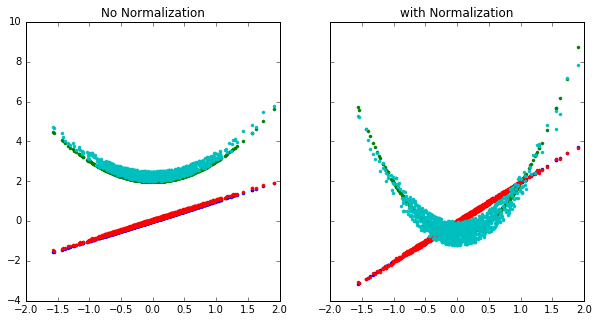

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,5))
ax1.set_title('No Normalization')
ax1.plot(a,y_true[:,0],'.')
ax1.plot(a,y_true[:,1],'.')
ax1.plot(a,y_pred[:,0],'.')
ax1.plot(a,y_pred[:,1],'.')
ax2.set_title('with Normalization')
ax2.plot(a,y_true_norm[:,0],'.')
ax2.plot(a,y_true_norm[:,1],'.')
ax2.plot(a,y_pred_norm[:,0],'.')
ax2.plot(a,y_pred_norm[:,1],'.')

Normalizing the outputs to have a unit norm

In [9]:
##scaling individual samples to have unit norm
y_all = np.hstack((y_true,y_pred))
y_all_norm = preprocessing.normalize(y_all,norm='l2',axis=0)

y_true_norm = y_all_norm[:,0:2]#preprocessing.normalize(y_true,norm='l2',axis=0)
y_pred_norm = y_all_norm[:,2:4]#preprocessing.normalize(y_pred,norm='l2',axis=0)

print 'raw values:        ', r2_score(y_true_norm, y_pred_norm, multioutput='raw_values')
print 'uniform average:   ', r2_score(y_true_norm, y_pred_norm, multioutput='uniform_average')
print 'variance_weighted: ', r2_score(y_true_norm, y_pred_norm, multioutput='variance_weighted')

raw values:         [ 0.9865203   0.87873772]
uniform average:    0.932629008303
variance_weighted:  0.983522195577


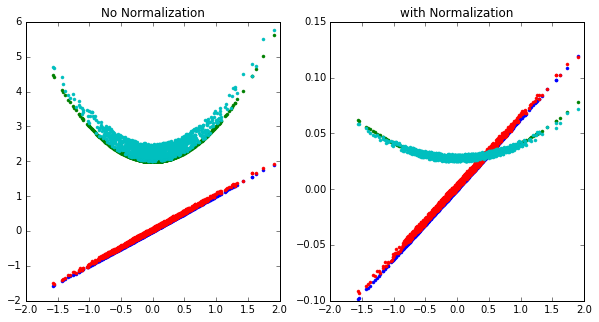

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.set_title('No Normalization')
ax1.plot(a,y_true[:,0],'.')
ax1.plot(a,y_true[:,1],'.')
ax1.plot(a,y_pred[:,0],'.')
ax1.plot(a,y_pred[:,1],'.')
ax2.set_title('with Normalization')
ax2.plot(a,y_true_norm[:,0],'.')
ax2.plot(a,y_true_norm[:,1],'.')
ax2.plot(a,y_pred_norm[:,0],'.')
ax2.plot(a,y_pred_norm[:,1],'.')

## conclusion: normalization is a bad idea!!!